# Multimodal Video RAG with Milvus and Pixtral

## Goal of this Notebook

In this Notebook, we will explore different techniques for video analysis and retrieval:

### 1️⃣ **Process and Store Video Data:**
Learn how to extract frames and audio from YouTube videos, and store this multimodal data efficiently in [Milvus](https://milvus.io/), a powerful vector database.

### 2️⃣ **Build Multimodal Indexes:**
Discover how to create and use indexes for both text and images using Milvus and Llama Index, enabling fast and accurate retrieval of video content.

### 3️⃣ **Implement Retrieval Augmentation:**
Explore techniques to fetch relevant images and context to enhance user queries, improving the quality and relevance of responses.

### 4️⃣ **Leverage Pixtral for Multimodal Reasoning:**
Learn to use [Pixtral](https://huggingface.co/mistralai/Pixtral-12B-2409), a state-of-the-art vision-language model from Mistral AI, for advanced multimodal reasoning and response generation.

### 5️⃣ **Scale with Cloud-Based Inference:**
Implement cloud-based inference using [Koyeb](https://www.koyeb.com/) to deploy Pixtral efficiently, we are using it in combination with vLLM.

### 🔍 **Summary**
By the end of this notebook, you'll have built a Multimodal Video RAG system that can understand and analyze video content comprehensively. You'll gain hands-on experience with Milvus for vector storage, Pixtral for multimodal reasoning, and Koyeb inference for scalable processing.

This system demonstrates advanced AI capabilities including:
- AI-powered video understanding
- Dynamic multimodal fusion of visual, audio, and textual data
- Context-rich prompting for improved LLM responses
- Scalable processing of complex video content

---

# Milvus
Milvus is an open-source vector database that powers AI applications with vector embeddings and similarity search.

In this notebook, we use [Milvus Standalone](https://milvus.io/docs/install_standalone-docker.md). It is a single-machine server deployment. All components of Milvus Standalone are packed into a single Docker image, making deployment convenient. 

![Milvus](https://github.com/milvus-io/artwork/blob/master/horizontal/color/milvus-horizontal-color.png?raw=true)



# Llama Index 
LlamaIndex is a data framework for your LLM application. It provides tools like:

* Data connectors ingest your existing data from their native source and format.
* Data indexes structure your data in intermediate representations that are easy and performant for LLMs to consume.
* Engines provide natural language access to your data.
* Agents are LLM-powered knowledge workers augmented by tools, from simple helper functions to API integrations and more.

# Mistral AI 
Mistral AI is a research lab building LLMs and Embeddings Models, they recently released new versions of their models, Pixtral is their Multimodal Model of 12B parameters plus a 400M parameter vision encoder.

### Architecture:
Pixtral has two components: the Vision Encoder, which tokenizes images, and a Multimodal Transformer Decoder, which predicts the next text token given a sequence of text and images. The model is trained to predict the next text token on interleaved image and text data. This architecture allows Pixtral to process any number of images with arbitrary sizes in its large context window of 128K tokens.


![Pixtral Architecture.png](https://mistral.ai/images/news/pixtral-12b/pixtral-model-architecture.png)

# Overall Archicture of our Multi Modal RAG system

Our MultiModal RAG system processes and analyzes video content through several key stages:

1. **Video Processing**:
   - The input video is split into two streams:
     a) Images are extracted from the video frames
     b) Audio is converted to text using speech recognition

2. **Embedding Generation**:
   - Images are processed using CLIP to generate image embeddings
   - The extracted text is converted into text embeddings

3. **Data Storage**:
   - Both image and text embeddings are stored in Milvus, a vector database optimized for similarity search

4. **Query Processing**:
   - User queries are converted into embeddings
   - A semantic search is performed on both image and text data in Milvus

5. **Context Retrieval**:
   - Milvus returns similar data (images and text) based on the query

6. **Response Generation**:
   - The retrieved context is passed to Pixtral, a vision-language model (vLLM)
   - Pixtral generates a final response based on the query and the provided context

This architecture enables our system to understand and reason about video content using both visual and textual information, providing comprehensive and context-aware responses to user queries.

![MultiModal RAG Architecture](resources/multimodal_rag_architecture.png)

## Install Dependencies

In [ ]:
%pip install llama-index-vector-stores-milvus
%pip install llama-index-multi-modal-llms-mistralai llama-index-embeddings-mistralai

In [ ]:
%pip install llama-index-multi-modal-llms-openai
%pip install llama-index-embeddings-clip

In [ ]:
%pip install llama_index ftfy regex tqdm
%pip install -U openai-whisper
%pip install git+https://github.com/openai/CLIP.git
%pip install torch torchvision
%pip install matplotlib scikit-image
%pip install pymilvus
%pip install moviepy
%pip install pytube
%pip install pydub
%pip install SpeechRecognition
%pip install ffmpeg-python
%pip install soundfile

In [18]:
import base64
import json
import os
from pathlib import Path

import speech_recognition as sr
from dotenv import load_dotenv
from llama_index.core import Settings, SimpleDirectoryReader, StorageContext
from llama_index.core.indices import MultiModalVectorStoreIndex
from llama_index.core.schema import ImageNode
from llama_index.embeddings.mistralai import MistralAIEmbedding
from llama_index.vector_stores.milvus import MilvusVectorStore
from moviepy.editor import VideoFileClip
from openai import OpenAI

### Get your API Key for Mistral on https://console.mistral.ai/api-keys/

Check out how to Deploy vLLM on Koyeb here: https://www.koyeb.com/deploy/vllm

In [19]:
"""
load_dotenv reads key-value pairs from a .env file and can set them as environment variables.
This is useful to avoid leaking your API key for example :D
"""
import os

from dotenv import load_dotenv

load_dotenv()

True

# Default Embedding for Images 

The default embedding for images is [CLIP](https://github.com/openai/CLIP) from OpenAI. LlamaIndex is using this one by default when using Images so we do not need to define it. 

# Default Embeddings for Text

Given that we use Mistral AI Pixtral Model, we are going to use their Embedding Models as well. This embedding model is really good at Retrieval tasks, which is very useful for RAG systems.

https://docs.mistral.ai/capabilities/embeddings/

In [20]:
from llama_index.core import Settings
from llama_index.embeddings.mistralai import MistralAIEmbedding

Settings.embed_model = MistralAIEmbedding(
    "mistral-embed", api_key=os.getenv("MISTRAL_API_KEY")
)

### Download data

In [ ]:
video_path = "https://www.youtube.com/watch?v=d_qvLDhkg00"
output_video_path = "./video_data/"
output_folder = "./mixed_data/"
output_audio_path = "./mixed_data/output_audio.wav"

filepath = output_video_path + "gaussian.mp4"
Path(output_folder).mkdir(parents=True, exist_ok=True)

#### Download and process videos into appropriate format for generating/storing embeddings

In [22]:
import os

import matplotlib.pyplot as plt
from PIL import Image


def plot_images(image_paths, ax=None):
    if ax is None:
        fig = plt.figure(figsize=(16, 9))
        images_shown = 0
        for img_path in image_paths:
            if os.path.isfile(img_path):
                image = Image.open(img_path)
                plt.subplot(2, 3, images_shown + 1)
                plt.imshow(image)
                plt.xticks([])
                plt.yticks([])
                images_shown += 1
                if images_shown >= 7:
                    break
        return fig
    else:
        if os.path.isfile(image_paths[0]):  # Assume single image when ax is provided
            image = Image.open(image_paths[0])
            ax.imshow(image)
            ax.set_xticks([])
            ax.set_yticks([])
        return ax

## Video Processing Functions

The cell below defines several key functions for processing video content:

* `download_video()`: Downloads a video from a given URL, with a fallback to direct download if YouTube-specific methods fail.

* `video_to_images()`: Extracts frames from a video at 0.2 FPS and saves them as individual images.

* `video_to_audio()`: Extracts the audio track from a video file.

* `audio_to_text()`: Transcribes audio to text using the Whisper speech recognition model.

These functions form the foundation of our video processing pipeline, enabling us to extract multimodal data (images and text) from video content for further analysis.

In [23]:
import os
from typing import Dict

import requests
import speech_recognition as sr
from moviepy.editor import VideoFileClip
from pytube import YouTube


def download_video(url: str, output_path: str) -> Dict[str, str]:
    """
    Download a video from a given url and save it to the output path.

    Parameters:
    url (str): The url of the video to download.
    output_path (str): The path to save the video to.

    Returns:
    dict: A dictionary containing the metadata of the video.
    """
    try:
        yt = YouTube(url)
        metadata = {"Author": yt.author, "Title": yt.title, "Views": str(yt.views)}
        yt.streams.get_highest_resolution().download(
            output_path=output_path, filename="input_vid.mp4"
        )
    except Exception as e:
        print(f"Error with pytube: {e}")
        print("Attempting direct download...")

        # Fallback: direct download
        response = requests.get(url)
        if response.status_code == 200:
            with open(os.path.join(output_path, "input_vid.mp4"), "wb") as f:
                f.write(response.content)
            metadata = {"Author": "Unknown", "Title": "Unknown", "Views": "Unknown"}
        else:
            raise Exception("Failed to download video directly.")

    return metadata


def video_to_images(video_path: str, output_folder: str) -> str:
    local_video_path = video_path
    if video_path.startswith(("http://", "https://")):
        import yt_dlp

        ydl_opts = {
            "format": "best",
            "outtmpl": os.path.join(output_folder, "video.mp4"),
        }
        with yt_dlp.YoutubeDL(ydl_opts) as ydl:
            ydl.download([video_path])
        local_video_path = os.path.join(output_folder, "video.mp4")

    clip = VideoFileClip(local_video_path)
    clip.write_images_sequence(os.path.join(output_folder, "frame%04d.png"), fps=0.2)
    return local_video_path


def video_to_audio(video_path: str, output_audio_path: str) -> None:
    """
    Convert a video to audio and save it to the output path.

    Parameters:
    video_path (str): The path to the video file.
    output_audio_path (str): The path to save the audio to.
    """
    clip = VideoFileClip(video_path)
    audio = clip.audio
    audio.write_audiofile(output_audio_path)


def audio_to_text(audio_path: str) -> str:
    """
    Convert audio to text using the SpeechRecognition library.

    Parameters:
    audio_path (str): The path to the audio file.

    Returns:
    str: The text recognized from the audio.
    """
    recognizer = sr.Recognizer()
    audio = sr.AudioFile(audio_path)

    with audio as source:
        # Record the audio data
        audio_data = recognizer.record(source)

        try:
            # Recognize the speech
            text = recognizer.recognize_whisper(audio_data)
        except sr.UnknownValueError:
            print("Speech recognition could not understand the audio.")
            text = ""
        except sr.RequestError as e:
            print(f"Could not request results from service; {e}")
            text = ""

    return text

## Processing the Video

We convert our video into multiple modalities (images and text) that can be used for further analysis.

In [ ]:
Path(output_folder).mkdir(parents=True, exist_ok=True)


local_video_path = video_to_images(video_path, output_folder)
video_to_audio(local_video_path, output_audio_path)
text_data = audio_to_text(output_audio_path)
with open(os.path.join(output_folder, "output_text.txt"), "w") as file:
    file.write(text_data)
os.remove(output_audio_path)

## Instanciate Milvus and Load Data
Milvus is a popular open-source vector database that powers AI applications with highly performant and scalable vector similarity search.

* Setting the uri as a local file, e.g.`./milvus.db`, is the most convenient method, as it automatically utilizes Milvus Lite to store all data in this file.
* If you have large scale of data, say more than a million vectors, you can set up a more performant Milvus server on [Docker or Kubernetes](https://milvus.io/docs/quickstart.md). In this setup, please use the server uri, e.g.`http://localhost:19530`, as your uri.
* If you want to use [Zilliz Cloud](https://zilliz.com/cloud), the fully managed cloud service for Milvus, adjust the uri and token, which correspond to the [Public Endpoint and API key](https://docs.zilliz.com/docs/on-zilliz-cloud-console#cluster-details) in Zilliz Cloud.

#### Create the multi-modal index

`MultiModalVectorStoreIndex` supports building separate vector stores for image and text embedding vector stores. 

In [ ]:
from llama_index.core import SimpleDirectoryReader, StorageContext
from llama_index.core.indices import MultiModalVectorStoreIndex
from llama_index.vector_stores.milvus import MilvusVectorStore

text_store = MilvusVectorStore(
    uri="http://127.0.0.1:19530",
    collection_name="text_collection",
    overwrite=False,
    dim=1024,
)
image_store = MilvusVectorStore(
    uri="http://127.0.0.1:19530",
    collection_name="image_collection",
    overwrite=False,
    dim=512,
)

storage_context = StorageContext.from_defaults(
    vector_store=text_store, image_store=image_store
)

documents = SimpleDirectoryReader(output_folder).load_data()

index = MultiModalVectorStoreIndex.from_documents(
    documents,
    storage_context=storage_context,
)

#### Use index as retriever to fetch top k (5 in this example) results from the multimodal vector index

In [24]:
retriever_engine = index.as_retriever(similarity_top_k=5, image_similarity_top_k=5)

#### Set the RAG prompt template

We're preparing the prompt template for our RAG system:

1. We define metadata for the video, including author, title, and view count.
2. We create a structured prompt template (`qa_tmpl_str`) that includes:
   - Instructions for the AI model
   - Placeholders for context from the video
   - Video metadata
   - The user's query
   
This template will be used to format prompts for the AI model, ensuring it has all necessary information to provide accurate and contextual responses based on the video content.

In [25]:
import json

# metadata_vid = {}
metadata_vid = {
    "Author": "The B1M",
    "Title": "Inside Europe's $1BN Abandoned Mega-Build",
    "Views": 1120617,
}
metadata_str = json.dumps(metadata_vid)

qa_tmpl_str = (
    "Given the provided information, including relevant images and retrieved context from the video, \
 accurately and precisely answer the query without any additional prior knowledge.\n"
    "Please ensure honesty and responsibility."
    "---------------------\n"
    "Context: {context_str}\n"
    "Metadata for video: {metadata_str} \n"
    "---------------------\n"
    "Query: {query_str}\n"
    "Answer: "
)

#### Retrieve most similar text/image embeddings based on user query from Milvus

This cell defines a `retrieve` function that:

1. Takes a query string and uses the retriever engine to find relevant content
2. Processes the retrieval results, separating them into:
   - Image files (stored as file paths)
   - Text content
3. Displays text content for immediate review
4. Returns lists of retrieved image paths and text content

This function is crucial for our RAG system, as it fetches the most relevant information from our Milvus database based on the user's query, preparing both visual and textual context for the AI model to use in generating a response.

In [26]:
from llama_index.core.response.notebook_utils import display_source_node
from llama_index.core.schema import ImageNode


def retrieve(retriever_engine, query_str):
    retrieval_results = retriever_engine.retrieve(query_str)

    retrieved_image = []
    retrieved_text = []
    for res_node in retrieval_results:
        if isinstance(res_node.node, ImageNode):
            retrieved_image.append(res_node.node.metadata["file_path"])
        else:
            display_source_node(res_node, source_length=200)
            retrieved_text.append(res_node.text)

    return retrieved_image, retrieved_text

#### Fetching Multimodal Context for Our Query

Here's where the magic happens! We're:

1. Defining query about the building show in the video
2. Retrieving relevant images and text snippets
3. Bundling everything into a rich, multimodal context


**Node ID:** 7f7c0ee3-dccc-43cb-89a7-2a96ab02fb75<br>**Similarity:** 0.8010739088058472<br>**Text:** The walk you in here really is like stepping back in time. As soon as you come inside, that 1970s technoptimism really hits you. This is the boulevard, this is level zero. This is what most people ...<br>

**Node ID:** ef5fc344-4dce-42a9-a6a4-24e44282a9a4<br>**Similarity:** 0.7914209961891174<br>**Text:** This is the boulevard, this is level zero. This is what most people would experience as soon as they walked into this building. It's like I've stepped onto the set of Star Wars. It really is out of...<br>

**Node ID:** 876ad73d-43f5-42f0-9622-f87d23d39350<br>**Similarity:** 0.7862178087234497<br>**Text:** By suspending Halls 1 and 2, the architects effectively isolated them from vibrations and noise generated in other parts of the building, particularly the halls and spaces below and the surrounding...<br>

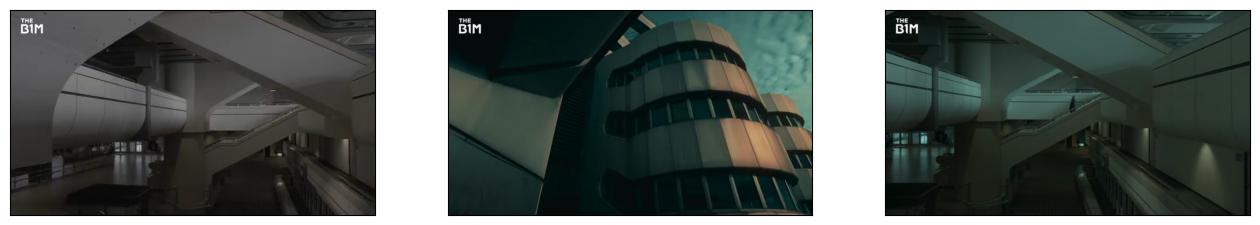

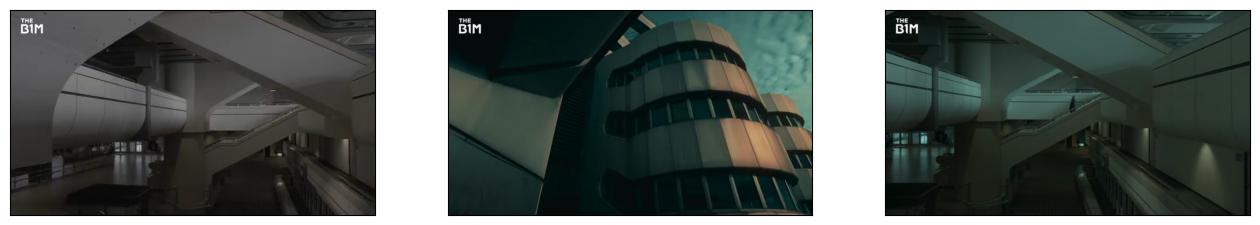

In [27]:
query_str = "Using examples from video, explain the architecture of this building"

img, txt = retrieve(retriever_engine=retriever_engine, query_str=query_str)
image_documents = SimpleDirectoryReader(
    input_dir=output_folder, input_files=img
).load_data()
context_str = "".join(txt)
plot_images(img)

#### Generate final response using Pixtral

In [ ]:
from llama_index.multi_modal_llms.mistralai import MistralAIMultiModal

pixtral_llm = MistralAIMultiModal(model="pixtral-12b-2409", max_new_tokens=300)

response_1 = pixtral_llm.complete(
    prompt=qa_tmpl_str.format(
        context_str=context_str, query_str=query_str, metadata_str=metadata_str
    ),
    image_documents=image_documents,
)

pprint(response_1.text)

# Call Pixtral with vLLM on Koyeb

This is where we use the power of Pixtral, our multimodal AI model! Here's what's happening:
1. We set up a connection to Pixtral running on Koyeb's cloud infrastructure with vLLM.
2. For each image, we:
   - Encode it to base64 format
   - Write a message combining our text query, context, and the image
   - Send it off to Pixtral for analysis
3. Pixtral then works its magic, interpreting both the text and image to generate a response.


In [28]:
import base64

from openai import OpenAI


def process_query_with_single_image(
    query_str, context_str, metadata_str, image_document
):
    client = OpenAI(
        base_url=os.getenv("KOYEB_ENDPOINT"),
        api_key=os.getenv("KOYEB_TOKEN"),
    )

    with open(image_document.image_path, "rb") as image_file:
        image_base64 = base64.b64encode(image_file.read()).decode("utf-8")

    messages = [
        {
            "role": "user",
            "content": [
                {
                    "type": "text",
                    "text": qa_tmpl_str.format(
                        context_str=context_str,
                        query_str=query_str,
                        metadata_str=metadata_str,
                    ),
                },
                {
                    "type": "image_url",
                    "image_url": {"url": f"data:image/jpeg;base64,{image_base64}"},
                },
            ],
        }
    ]

    try:
        completion = client.chat.completions.create(
            model="mistralai/Pixtral-12B-2409", messages=messages, max_tokens=300
        )
        response = completion.choices[0].message.content
        return response
    except Exception as e:
        return f"Error processing image {image_document.image_path}: {str(e)}"

In [29]:
import matplotlib.pyplot as plt
from IPython.display import Markdown, display


def plot_images(image_paths, ax=None):
    if ax is None:
        fig = plt.figure(figsize=(16, 9))
        images_shown = 0
        for img_path in image_paths:
            if os.path.isfile(img_path):
                image = Image.open(img_path)
                plt.subplot(2, 3, images_shown + 1)
                plt.imshow(image)
                plt.xticks([])
                plt.yticks([])
                images_shown += 1
                if images_shown >= 7:
                    break
        return fig
    else:
        if os.path.isfile(image_paths[0]):  # Assume single image when ax is provided
            image = Image.open(image_paths[0])
            ax.imshow(image)
            ax.set_xticks([])
            ax.set_yticks([])
        return ax


def process_query_with_multiple_images(
    query_str, context_str, metadata_str, image_documents
):
    for i, img_doc in enumerate(image_documents):
        response = process_query_with_single_image(
            query_str, context_str, metadata_str, img_doc
        )

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

        plot_images([img_doc.image_path], ax=ax1)
        ax1.set_title(f"Frame {i+1}")

        ax2.axis("off")
        ax2.text(
            0,
            1,
            f"Analysis for Frame {i+1}:\n\n{response}",
            verticalalignment="top",
            wrap=True,
            fontsize=10,
        )

        plt.tight_layout()
        display(fig)
        plt.close(fig)

        display(Markdown("---"))

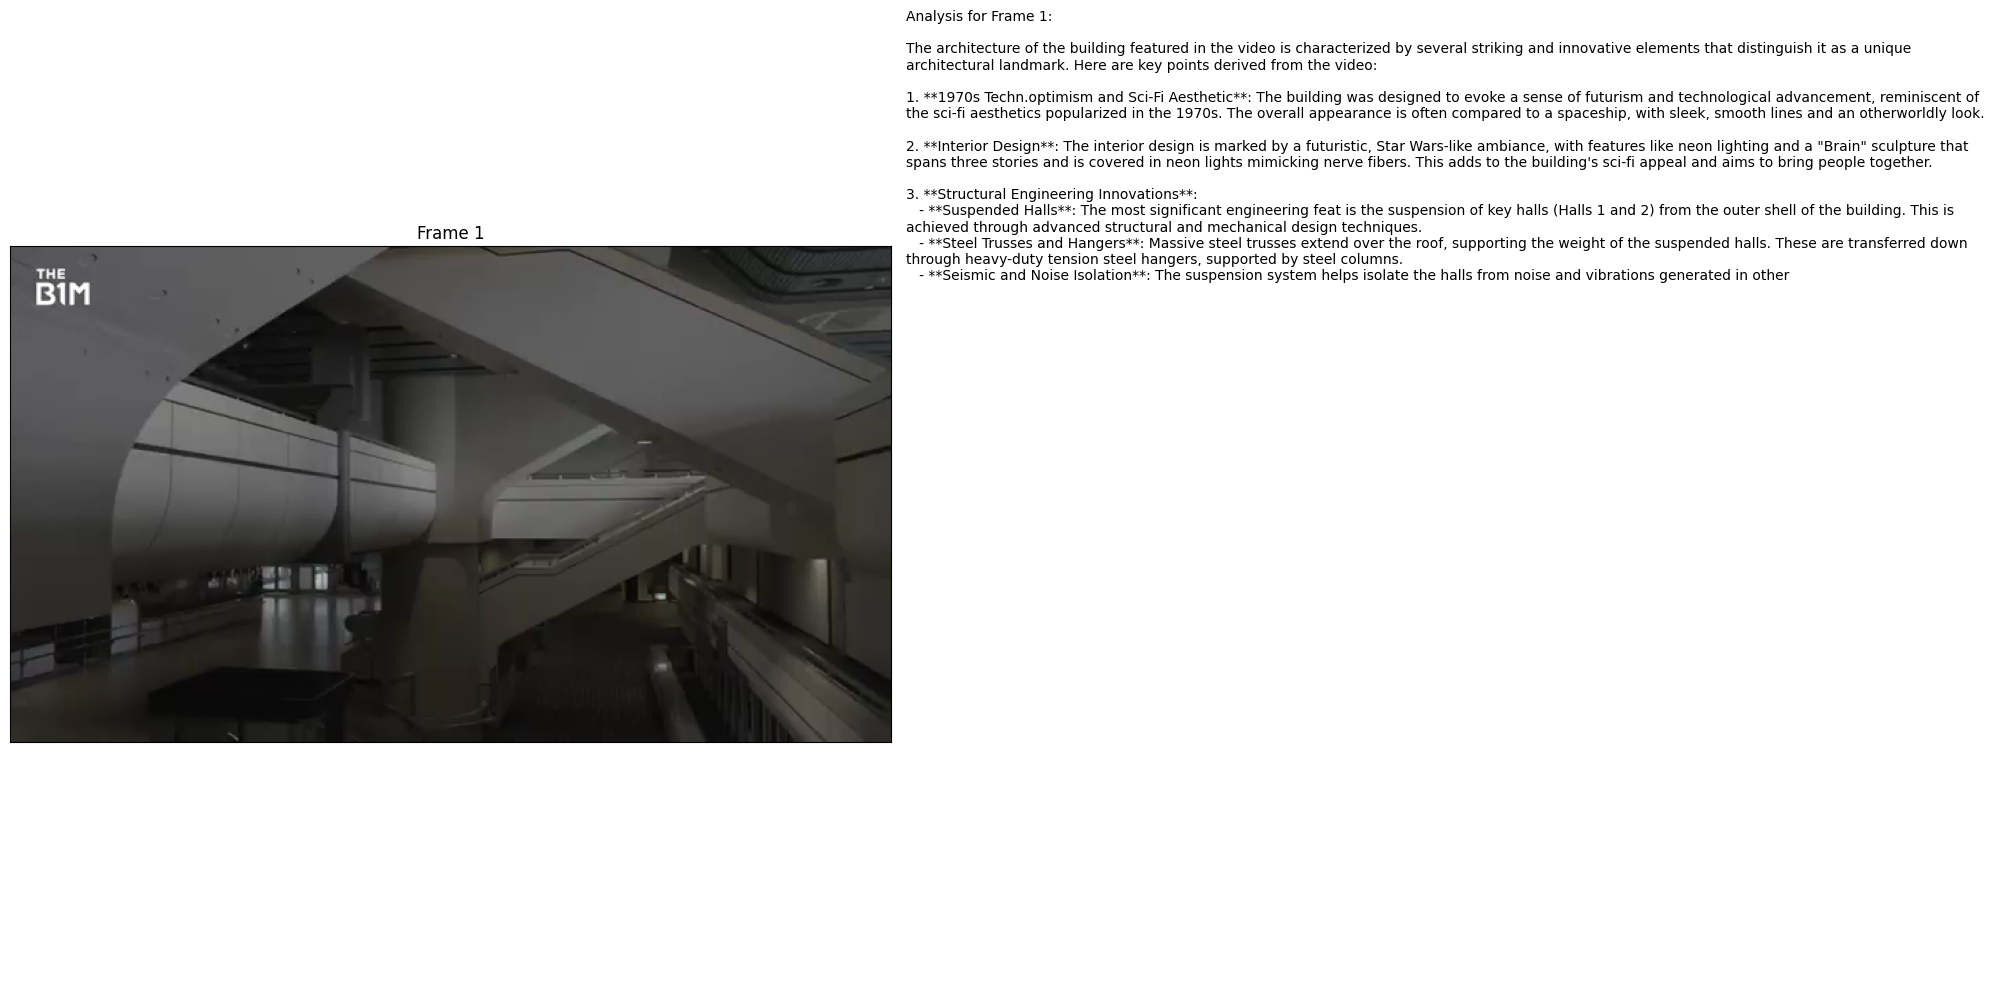

---

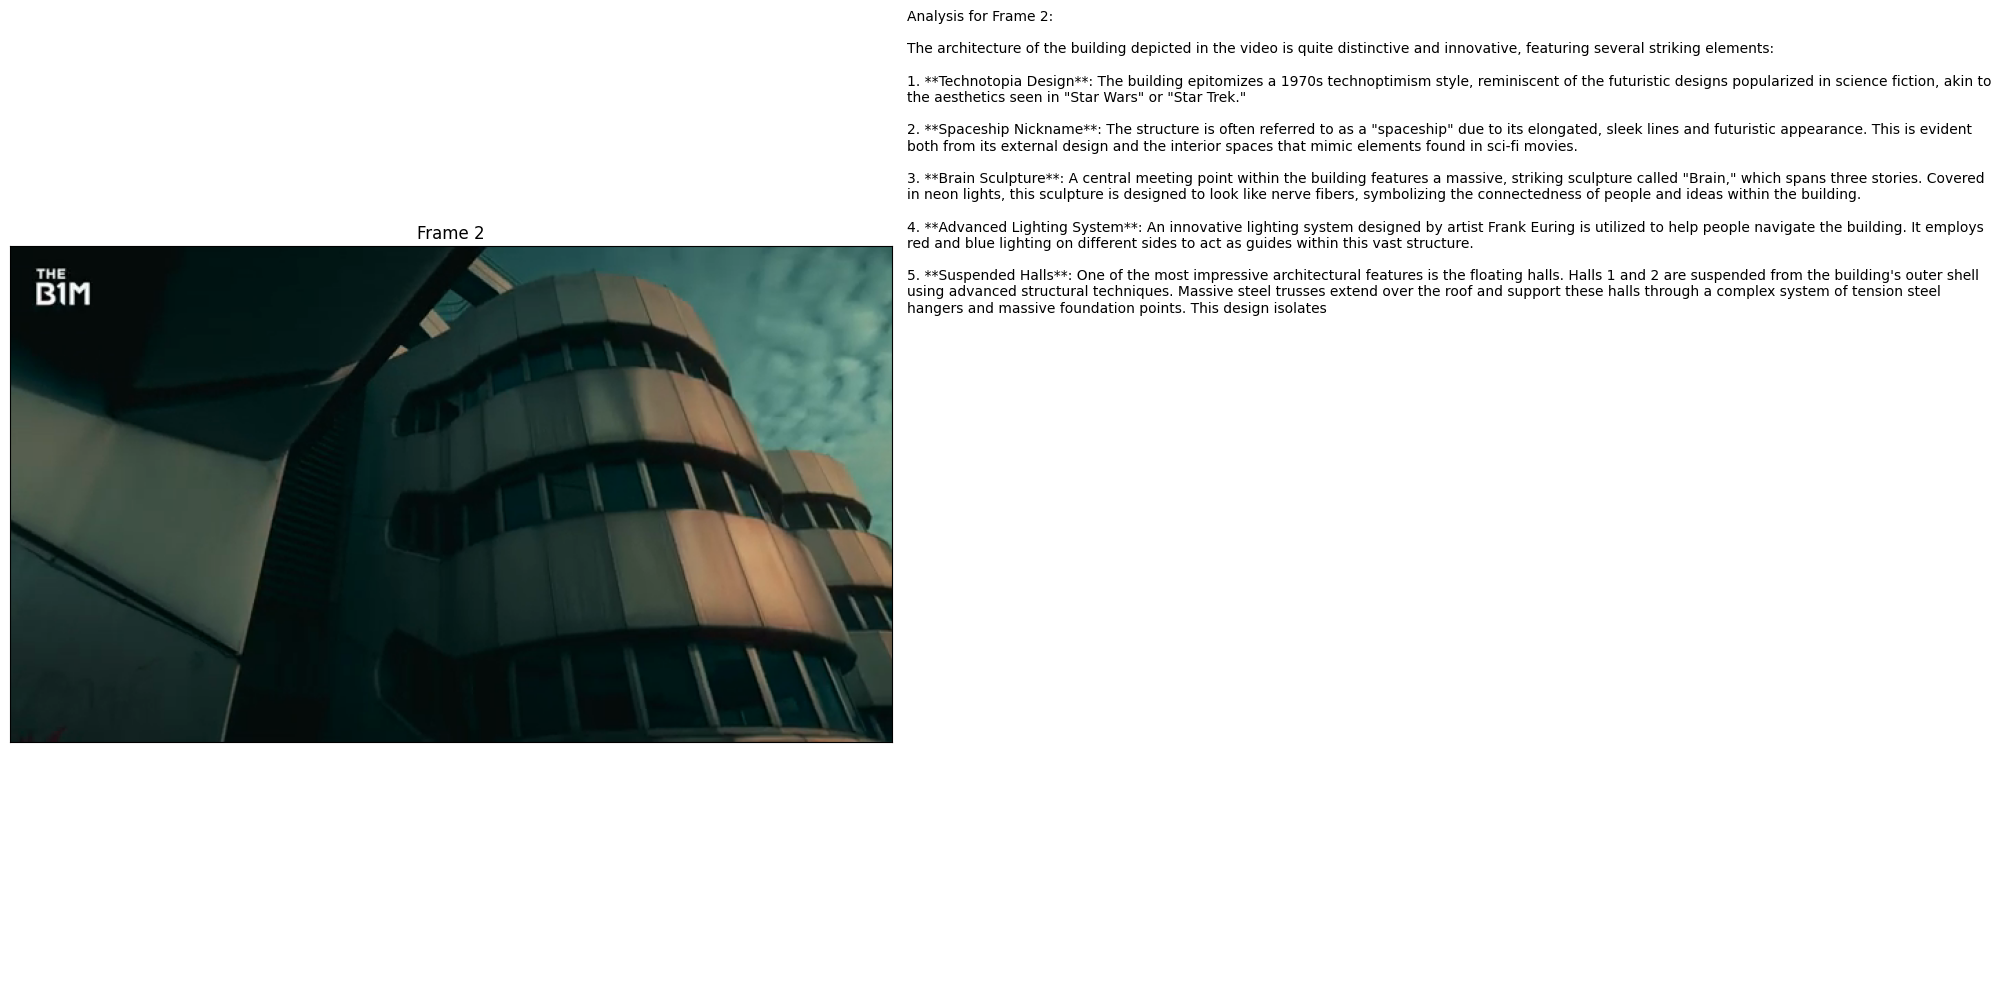

---

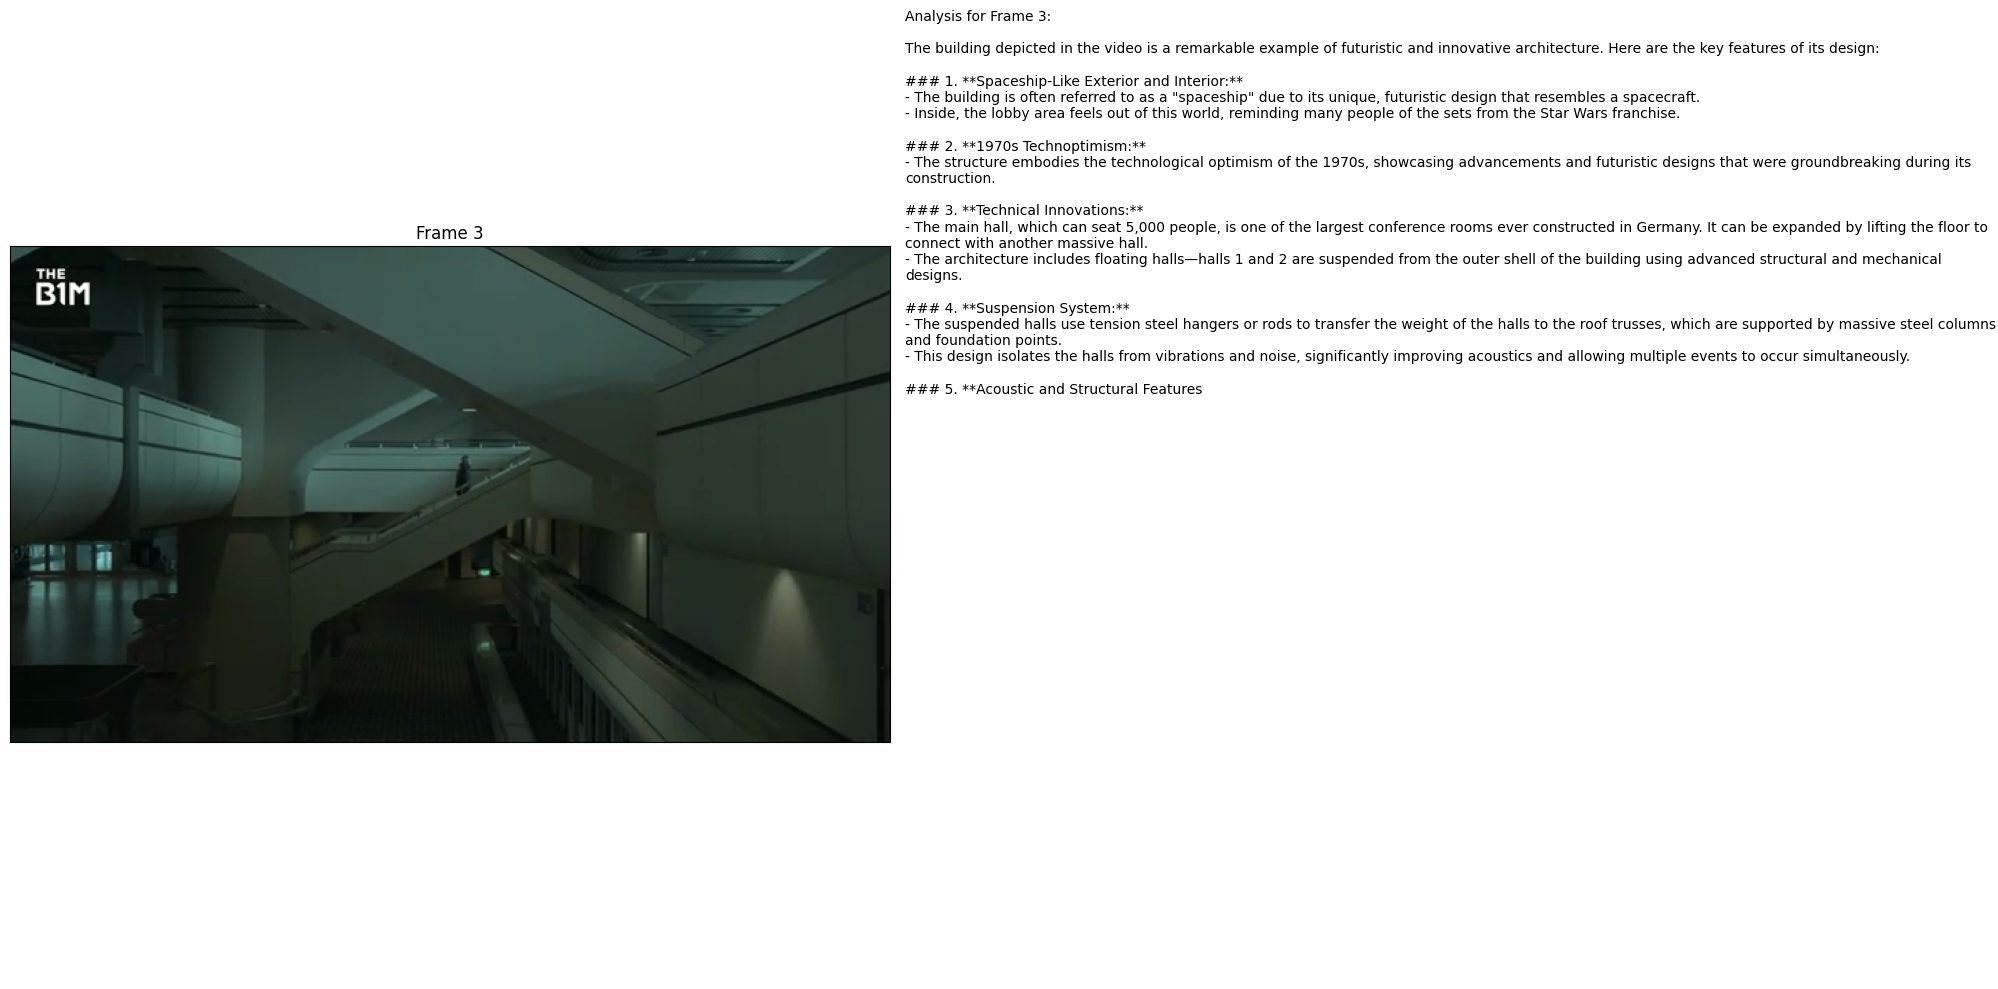

---

None


In [30]:
query_str = "Using examples from video, explain the architecture of this building"

metadata_str = "{}"
response = process_query_with_multiple_images(
    query_str, context_str, metadata_str, image_documents
)
print(response)

--- 

# Conclusion
In this notebook, we've explored the creation of a powerful Multimodal Video RAG system using Pixtral and Milvus. We've demonstrated how to:

1. Process and store video data.
2. Build multimodal indexes for efficient retrieval of both text and images with Milvus
3. Implement retrieval augmentation to enhance user queries
4. Leverage Pixtral, a state-of-the-art vision-language model, for advanced multimodal reasoning
5. Scale our system with Koyeb and vLLM

By combining those, we've created a system capable of understanding and analyzing video content.

# ⭐️ Github
We hope you found this tutorial on building a Multimodal Video RAG system with Milvus, Pixtral, and Koyeb informative and inspiring. If you enjoyed this project and found it useful, please consider giving us a star on [Github](https://github.com/milvus-io/milvus)! ⭐

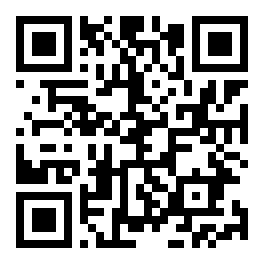

# 🤝 Add me on Linkedin!
If you have some questions related to Milvus, GenAI, etc, I am Stephen Batifol, you can add me on [LinkedIn](https://www.linkedin.com/in/stephen-batifol/) and I'll gladly help you.

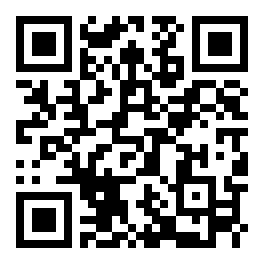